TODO 3: Run Martingale Explosiveness tests
1) In a seperate notebook for each setting ['poly-2', 'exp', 'power']:
2) Plot and compare results of martingale tests for [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] day max lookbacks

In [222]:
%matplotlib inline
import os, sys
import pandas as pd
import numpy as np
from datetime import timedelta
import statsmodels.api as sm
import requests
import matplotlib.pyplot as plt

In [223]:
class MartingaleTest:
    """ Sub- and Super-Martingale Trend Tests
    Ref: de Prado Section 17.3
    """
    # Hypothesis tests where null is b = 0.
    VALID_TYPES = {
        'poly-1',  # y_t =  c + a * t + b * t ^ 2
        'poly-2',  # log(y_t) = c + a * t + b * t ^ 2
        'exp',  # log(y_t) = c + b * t
        'power'  # log(y_t) = c + b * log(t)
    }

    def __init__(self, ticks_required, test_type
                        ,minimum_sample_length_perc=0.5):
        self.ticks_required = ticks_required
        assert test_type in self.VALID_TYPES, 'Invalid test_type {}'.format(
            test_type)
        self.test_type = test_type
        
        # out name should uniquely identify the feature with all its args
        self.output_column_names = [
            '{0}_martingale_test_{1}'.format(self.ticks_required, test_type)]
        
        
        self.minimum_sample_length = int(ticks_required * minimum_sample_length_perc) #what is the issue here??
        assert self.minimum_sample_length <= ticks_required

        x_time = np.array(range(1, self.ticks_required + 1))
        x_time_2 = x_time ** 2
        x_time_log = np.log(x_time)
        constant = np.ones(self.ticks_required)

        y_x_dict = {
            'poly-1': (None, np.column_stack([constant, x_time, x_time_2])),
            'poly-2': (np.log, np.column_stack([constant, x_time, x_time_2])),
            'exp':  (np.log, np.column_stack([constant, x_time])),
            'power': (np.log, np.column_stack([constant, x_time_log]))
        }

        def compute_stat(y):
            start_points = range(0, len(y) - self.minimum_sample_length)
            y_func, x = y_x_dict.get(self.test_type)

            y_ = y
            if y_func:
                y_ = y_func(y)

            results = []
            # TODO: Investigate usage of parameter phi to select timescale of selected bubbles.
            for sp in start_points:
                model = sm.OLS(y_[sp:], x[sp:])
                # We are interested in the t-value of the highest order term.
                # This will be the last term by our construction of x.
                # TODO: Investigate splitting growth and collapse models by looking at the sign of t-values.
                results.append(abs(model.fit().tvalues[-1]))

            return max(results)

        self.compute_stat = compute_stat

    #def generate_bulk(self, reg_ticks: pd.DataFrame):
     #   close = reg_ticks['close']
      #  rolling = close.rolling(self.ticks_required,
       #                         min_periods=self.ticks_required)

        #data = (
         #   rolling.apply(self.compute_stat, raw=True).values).astype(np.float)

        #return pd.DataFrame(index=reg_ticks.index,
         #                   data=data,
          #                  columns=self.output_column_names)
    
    def generate_bulk(self, reg_ticks: pd.DataFrame):
        log_prices = np.log(reg_ticks['close'])
        martingale_test_stats = []
        '''
        for ticks in self.ticks_required:
            rolling = log_prices.rolling(
                ticks, min_periods=ticks)
            n_tick = range(1, ticks)
            thresholds = np.sqrt(4.6 + np.log(n_tick))
            martingale_test_stat = (rolling.apply(lambda x: self.compute_stat(x, n_tick, thresholds), raw=True).values).astype(np.float)
            martingale_test_stats.append(martingale_test_stat) '''
            
        '''
        rolling = log_prices.rolling(
            self.ticks_required, min_periods=self.ticks_required)
        n_tick = range(1, self.ticks_required)
        thresholds = np.sqrt(4.6 + np.log(n_tick))
        martingale_test_stat = (rolling.apply(lambda x: self.compute_stat(x, n_tick, thresholds), raw=True).values).astype(np.float)
        martingale_test_stat = 
        martingale_test_stats.append(martingale_test_stat)

        martingale_test_stats = np.array(martingale_test_stats)
        return pd.DataFrame(index=reg_ticks.index,
                            data=martingale_test_stats.transpose(),
                            columns=self.output_column_names)
'''



        rolling = log_prices.rolling(self.ticks_required, min_periods=self.ticks_required)
        data = (
            rolling.apply(self.compute_stat, raw=True).values).astype(np.float)

        return pd.DataFrame(index=reg_ticks.index,data=data,columns=self.output_column_names)
     

In [224]:
class StructuralBreakFeatures:
    DEFAULT_FEATURES_TO_CALCULATE = []
    DROP_COLUMNS = ['open', 'high', 'low']

    def __init__(self,
                 features_to_calculate=None,
                 interval_size: timedelta=timedelta(days=1),
                 drop_columns=None):
        if features_to_calculate is None:
            features_to_calculate = self.DEFAULT_FEATURES_TO_CALCULATE

        if drop_columns is None:
            drop_columns = self.DROP_COLUMNS

        # Create feature generator and compute features
        self.interval_type = 'time'
        self.interval_size = interval_size
        self.features_to_calculate = features_to_calculate
        self.drop_columns = drop_columns

    def get_feature_data(self, data_df):
        """ Compute all features.
        :param data_df:
        :return:
        """
        #feature_generator = MartingaleTest(self.features_to_calculate, 'poly-2')
        feature_generator = MartingaleTest(self.features_to_calculate, 'poly-2')
        data_df_enriched = data_df.join(feature_generator.generate_bulk(data_df))
        '''
        for tick_count in self.features_to_calculate:
            feature_generator = MartingaleTest(tick_count, 'poly-2')
            data_df_enriched = data_df.join(feature_generator.generate_bulk(data_df))

            feature_generator = FeatureGenerator(self.interval_type,
                                                 self.interval_size,
                                                 self.features_to_calculate)
            data_df_enriched = feature_generator.process_bulk_ticks(data_df)
            data_df_enriched = data_df_enriched.drop(self.DROP_COLUMNS, axis=1)
        '''
        return data_df_enriched

In [225]:
POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv (open/high/low/close/volume) data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [226]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=0, end=9999999999, period=86400)
df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,244.00,1424304000,0.330,225.00,0.330000,0.193117,46.276313,239.627778
1,240.25,1424390400,245.000,240.25,240.250118,0.230429,55.894897,242.568479
2,245.00,1424476800,245.000,245.00,245.000000,0.060091,14.722239,245.000000
3,235.00,1424563200,249.000,235.00,245.000000,0.539055,129.121248,239.532608
4,235.00,1424649600,235.001,235.00,235.000002,0.410926,96.567562,235.000062


In [227]:
df['time'] = pd.to_datetime(df['date'], unit='s')
df.index = df['time']
df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time
time,,,,,,,,,
2015-02-19,244.00,1424304000,0.330,225.00,0.330000,0.193117,46.276313,239.627778,2015-02-19
2015-02-20,240.25,1424390400,245.000,240.25,240.250118,0.230429,55.894897,242.568479,2015-02-20
2015-02-21,245.00,1424476800,245.000,245.00,245.000000,0.060091,14.722239,245.000000,2015-02-21
2015-02-22,235.00,1424563200,249.000,235.00,245.000000,0.539055,129.121248,239.532608,2015-02-22
2015-02-23,235.00,1424649600,235.001,235.00,235.000002,0.410926,96.567562,235.000062,2015-02-23


In [228]:
df_prices = df[['close','high','low','open','weightedAverage']]
log_df = np.log(df_prices)
log_df.head()

,close,high,low,open,weightedAverage
time,,,,,
2015-02-19,5.497168,-1.108663,5.416100,-1.108663,5.479087
2015-02-20,5.481680,5.501258,5.481680,5.481681,5.491284
2015-02-21,5.501258,5.501258,5.501258,5.501258,5.501258
2015-02-22,5.459586,5.517453,5.459586,5.501258,5.478690
2015-02-23,5.459586,5.459590,5.459586,5.459586,5.459586


In [229]:
df_daily = df
df_log_daily = log_df
df_daily['time'] = pd.to_datetime(df_daily.index)
df_log_daily['time'] = pd.to_datetime(df_log_daily.index)

In [230]:
df_daily.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time
time,,,,,,,,,
2015-02-19,244.00,1424304000,0.330,225.00,0.330000,0.193117,46.276313,239.627778,2015-02-19
2015-02-20,240.25,1424390400,245.000,240.25,240.250118,0.230429,55.894897,242.568479,2015-02-20
2015-02-21,245.00,1424476800,245.000,245.00,245.000000,0.060091,14.722239,245.000000,2015-02-21
2015-02-22,235.00,1424563200,249.000,235.00,245.000000,0.539055,129.121248,239.532608,2015-02-22
2015-02-23,235.00,1424649600,235.001,235.00,235.000002,0.410926,96.567562,235.000062,2015-02-23


In [231]:
df_log_daily.head()

,close,high,low,open,weightedAverage,time
time,,,,,,
2015-02-19,5.497168,-1.108663,5.416100,-1.108663,5.479087,2015-02-19
2015-02-20,5.481680,5.501258,5.481680,5.481681,5.491284,2015-02-20
2015-02-21,5.501258,5.501258,5.501258,5.501258,5.501258,2015-02-21
2015-02-22,5.459586,5.517453,5.459586,5.501258,5.478690,2015-02-22
2015-02-23,5.459586,5.459590,5.459586,5.459586,5.459586,2015-02-23


In [232]:
features = [2,4,8,16,32,64,128,256,512,1024]
for item in features:
    martingale_poly2_features = StructuralBreakFeatures(
        features_to_calculate=item)

martingale_poly2_enriched = martingale_poly2_features.get_feature_data(df_daily)
martingale_poly2_enriched.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,1024_martingale_test_poly-2
time,,,,,,,,,,
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,47.550029
2018-10-09,6654.918164,1539043200,6678.999987,6610.000000,6674.063726,238.709058,1.587726e+06,6651.299989,2018-10-09,47.587083
2018-10-10,6630.200000,1539129600,6655.999998,6500.000000,6655.999998,458.869558,3.018852e+06,6578.889060,2018-10-10,47.625737
2018-10-11,6250.284490,1539216000,6632.776373,6202.349831,6630.200000,1927.565051,1.222207e+07,6340.678237,2018-10-11,47.712789
2018-10-12,6317.472516,1539302400,6326.969000,6200.000000,6253.000000,202.688348,1.266891e+06,6250.437690,2018-10-12,47.788781


In [233]:
martingale_poly2_enriched.describe()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,1024_martingale_test_poly-2
count,1332.000000,1.332000e+03,1332.000000,1332.000000,1332.000000,1332.000000,1.332000e+03,1332.000000,309.000000
mean,3071.683215,1.481803e+09,3177.257007,2937.889232,3067.238059,3285.037597,1.587615e+07,3058.093540,38.734435
std,3844.051585,3.323459e+07,4010.299350,3633.347015,3844.477367,5861.001940,3.320017e+07,3819.235213,11.051775
min,178.719313,1.424304e+09,0.330000,99.000000,0.330000,0.000000,0.000000e+00,207.450144,17.933992
25%,409.960000,1.453054e+09,419.997392,399.887500,409.397250,35.909858,1.379017e+04,410.579737,28.796611
50%,780.455800,1.481803e+09,787.804666,771.182148,778.613189,715.440567,8.495166e+05,779.182454,41.210705
75%,6241.250001,1.510553e+09,6379.096390,6032.564958,6226.091999,4202.227243,1.736765e+07,6244.181370,47.285490
max,19223.000000,1.539302e+09,19903.440214,18569.637853,19223.000000,48896.616808,3.960385e+08,19236.130652,55.902579


In [ ]:
'''
for feature in features:
    fig, ax = plt.subplots(figsize=(16,9))
    martingale = '{0}_martingale'.format(feature)
    martingale_test = '{0}_martingale_test_poly-2'.format(feature)
    martingale_poly2_enriched['close'].plot(ax=ax, style='b-', legend=True)
    martingale_poly2_enriched[martingale] = martingale_poly2_enriched['close'].where(martingale_poly2_enriched[martingale_test] == 1.0, other=0.0)
    martingale_poly2_enriched[martingale].plot(ax=ax, style='ro', secondary_y=False, legend=True)
'''

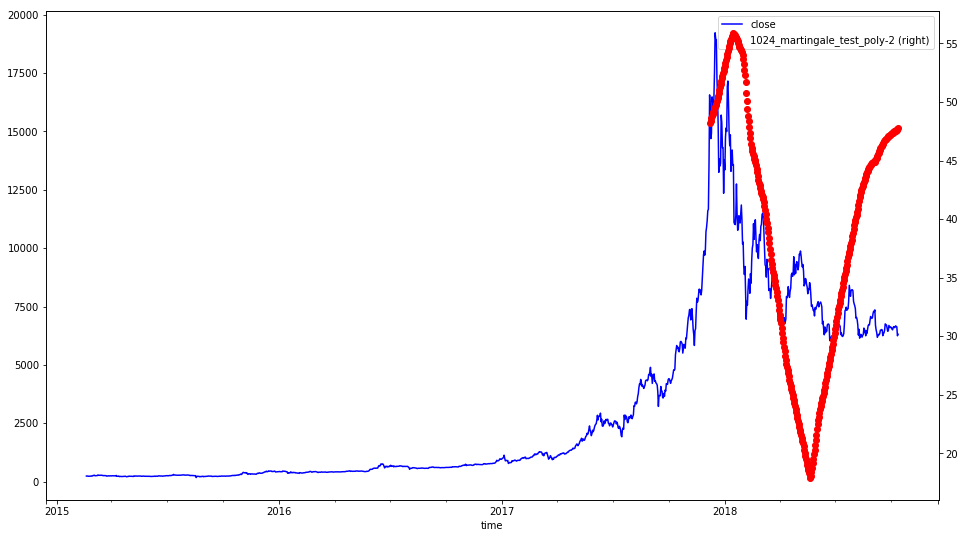

In [235]:
fig, ax = plt.subplots(figsize=(16,9))
martingale_poly2_enriched['close'].plot(ax=ax,style='b-', legend=True)
martingale_poly2_enriched['1024_martingale_test_poly-2'].plot(ax=ax,style='ro',secondary_y=True,legend=True)

In [236]:
features = [2,4,8,16,32,64,128,256,512]
for item in features:
    martingale_poly2_features = StructuralBreakFeatures(
        features_to_calculate=item)

martingale_poly2_enriched = martingale_poly2_features.get_feature_data(df_daily)
martingale_poly2_enriched.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,512_martingale_test_poly-2
time,,,,,,,,,,
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,34.480090
2018-10-09,6654.918164,1539043200,6678.999987,6610.000000,6674.063726,238.709058,1.587726e+06,6651.299989,2018-10-09,34.286050
2018-10-10,6630.200000,1539129600,6655.999998,6500.000000,6655.999998,458.869558,3.018852e+06,6578.889060,2018-10-10,34.093410
2018-10-11,6250.284490,1539216000,6632.776373,6202.349831,6630.200000,1927.565051,1.222207e+07,6340.678237,2018-10-11,33.964923
2018-10-12,6317.472516,1539302400,6326.969000,6200.000000,6253.000000,202.688348,1.266891e+06,6250.437690,2018-10-12,33.842231


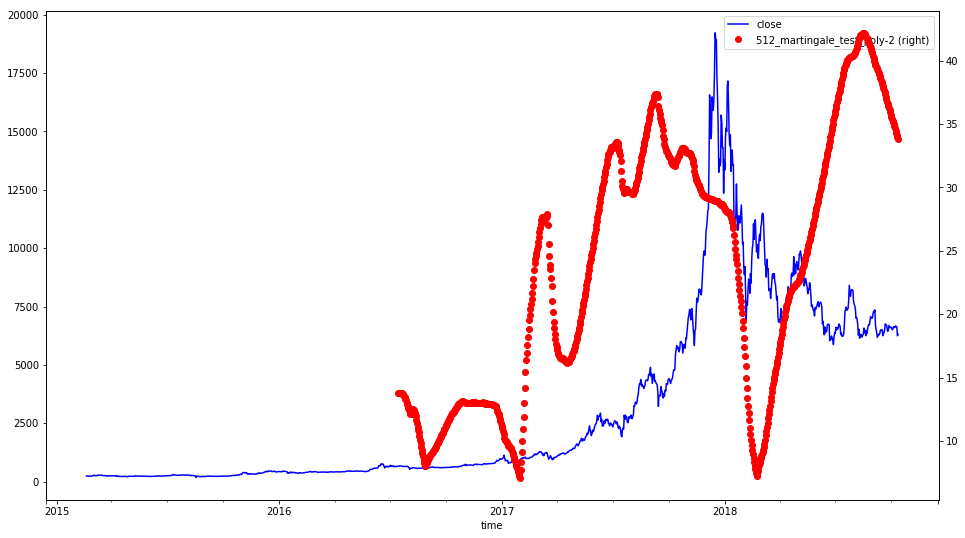

In [237]:
fig, ax = plt.subplots(figsize=(16,9))
martingale_poly2_enriched['close'].plot(ax=ax, style='b-', legend=True)
martingale_poly2_enriched['512_martingale_test_poly-2'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [238]:
features = [2,4,8,16,32,64,128,256]
for item in features:
    martingale_poly2_features = StructuralBreakFeatures(
        features_to_calculate=item)

martingale_poly2_enriched = martingale_poly2_features.get_feature_data(df_daily)
martingale_poly2_enriched.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,256_martingale_test_poly-2
time,,,,,,,,,,
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,8.408766
2018-10-09,6654.918164,1539043200,6678.999987,6610.000000,6674.063726,238.709058,1.587726e+06,6651.299989,2018-10-09,8.476626
2018-10-10,6630.200000,1539129600,6655.999998,6500.000000,6655.999998,458.869558,3.018852e+06,6578.889060,2018-10-10,8.535021
2018-10-11,6250.284490,1539216000,6632.776373,6202.349831,6630.200000,1927.565051,1.222207e+07,6340.678237,2018-10-11,8.439495
2018-10-12,6317.472516,1539302400,6326.969000,6200.000000,6253.000000,202.688348,1.266891e+06,6250.437690,2018-10-12,8.380140


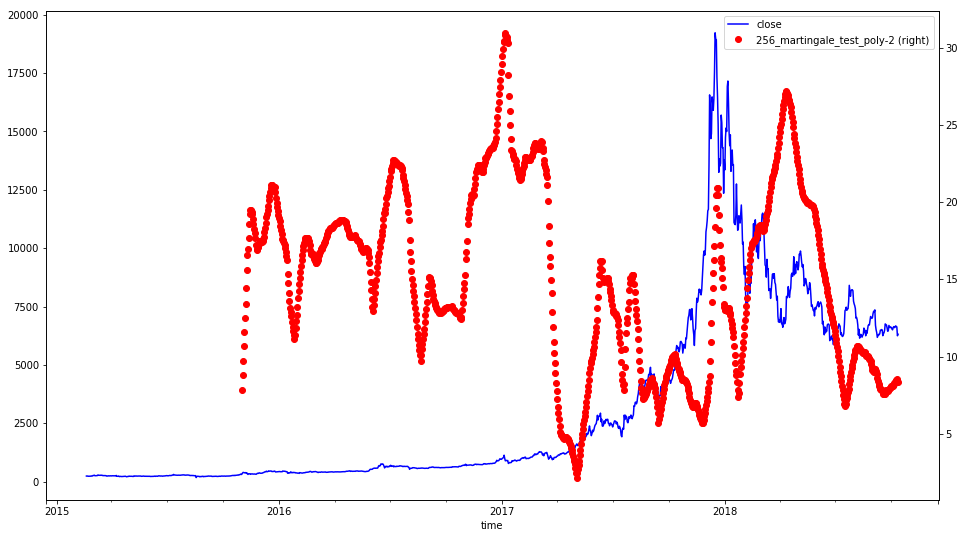

In [239]:
fig, ax = plt.subplots(figsize=(16,9))
martingale_poly2_enriched['close'].plot(ax=ax, style='b-', legend=True)
martingale_poly2_enriched['256_martingale_test_poly-2'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [240]:
features = [2,4,8,16,32,64,128]
for item in features:
    martingale_poly2_features = StructuralBreakFeatures(
        features_to_calculate=item)

martingale_poly2_enriched = martingale_poly2_features.get_feature_data(df_daily)
martingale_poly2_enriched.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,128_martingale_test_poly-2
time,,,,,,,,,,
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,5.819446
2018-10-09,6654.918164,1539043200,6678.999987,6610.000000,6674.063726,238.709058,1.587726e+06,6651.299989,2018-10-09,5.900559
2018-10-10,6630.200000,1539129600,6655.999998,6500.000000,6655.999998,458.869558,3.018852e+06,6578.889060,2018-10-10,5.957533
2018-10-11,6250.284490,1539216000,6632.776373,6202.349831,6630.200000,1927.565051,1.222207e+07,6340.678237,2018-10-11,5.678354
2018-10-12,6317.472516,1539302400,6326.969000,6200.000000,6253.000000,202.688348,1.266891e+06,6250.437690,2018-10-12,5.496727


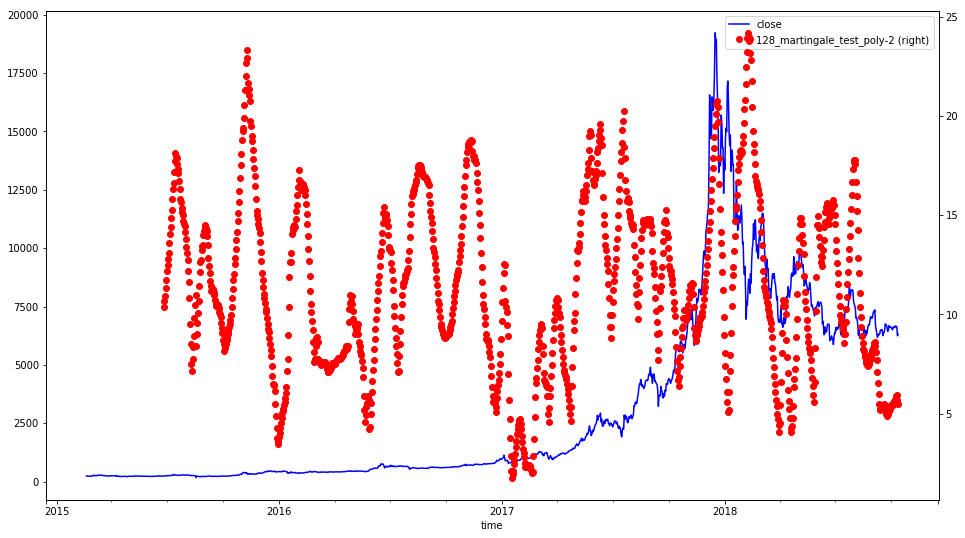

In [241]:
fig, ax = plt.subplots(figsize=(16,9))
martingale_poly2_enriched['close'].plot(ax=ax, style='b-', legend=True)
martingale_poly2_enriched['128_martingale_test_poly-2'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [242]:
features = [2,4,8,16,32,64]
for item in features:
    martingale_poly2_features = StructuralBreakFeatures(
        features_to_calculate=item)

martingale_poly2_enriched = martingale_poly2_features.get_feature_data(df_daily)
martingale_poly2_enriched.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,64_martingale_test_poly-2
time,,,,,,,,,,
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,4.839070
2018-10-09,6654.918164,1539043200,6678.999987,6610.000000,6674.063726,238.709058,1.587726e+06,6651.299989,2018-10-09,4.901354
2018-10-10,6630.200000,1539129600,6655.999998,6500.000000,6655.999998,458.869558,3.018852e+06,6578.889060,2018-10-10,4.898517
2018-10-11,6250.284490,1539216000,6632.776373,6202.349831,6630.200000,1927.565051,1.222207e+07,6340.678237,2018-10-11,4.057210
2018-10-12,6317.472516,1539302400,6326.969000,6200.000000,6253.000000,202.688348,1.266891e+06,6250.437690,2018-10-12,4.545038


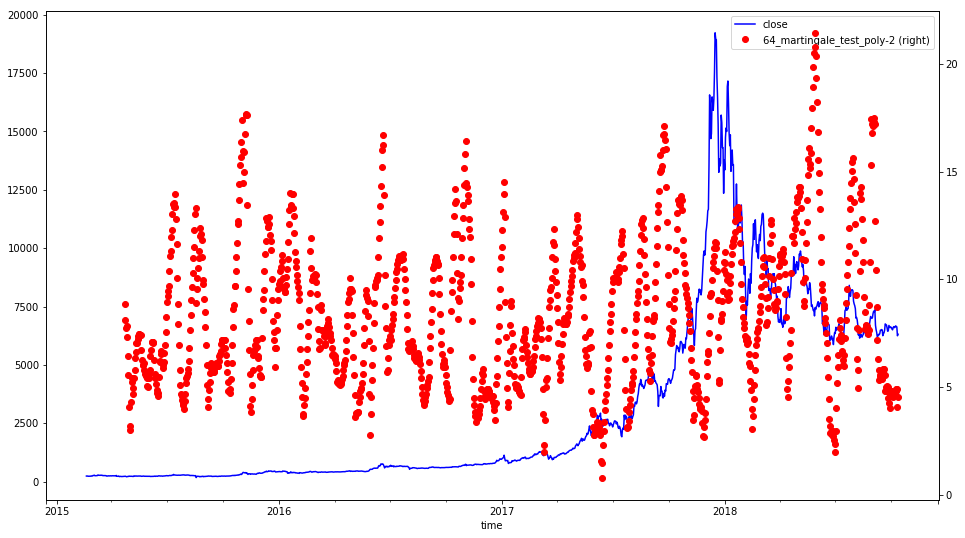

In [243]:
fig, ax = plt.subplots(figsize=(16,9))
martingale_poly2_enriched['close'].plot(ax=ax, style='b-', legend=True)
martingale_poly2_enriched['64_martingale_test_poly-2'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [244]:
features = [2,4,8,16,32]
for item in features:
    martingale_poly2_features = StructuralBreakFeatures(
        features_to_calculate=item)

martingale_poly2_enriched = martingale_poly2_features.get_feature_data(df_daily)
martingale_poly2_enriched.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,32_martingale_test_poly-2
time,,,,,,,,,,
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,2.713151
2018-10-09,6654.918164,1539043200,6678.999987,6610.000000,6674.063726,238.709058,1.587726e+06,6651.299989,2018-10-09,2.703263
2018-10-10,6630.200000,1539129600,6655.999998,6500.000000,6655.999998,458.869558,3.018852e+06,6578.889060,2018-10-10,2.474959
2018-10-11,6250.284490,1539216000,6632.776373,6202.349831,6630.200000,1927.565051,1.222207e+07,6340.678237,2018-10-11,2.953189
2018-10-12,6317.472516,1539302400,6326.969000,6200.000000,6253.000000,202.688348,1.266891e+06,6250.437690,2018-10-12,3.598397


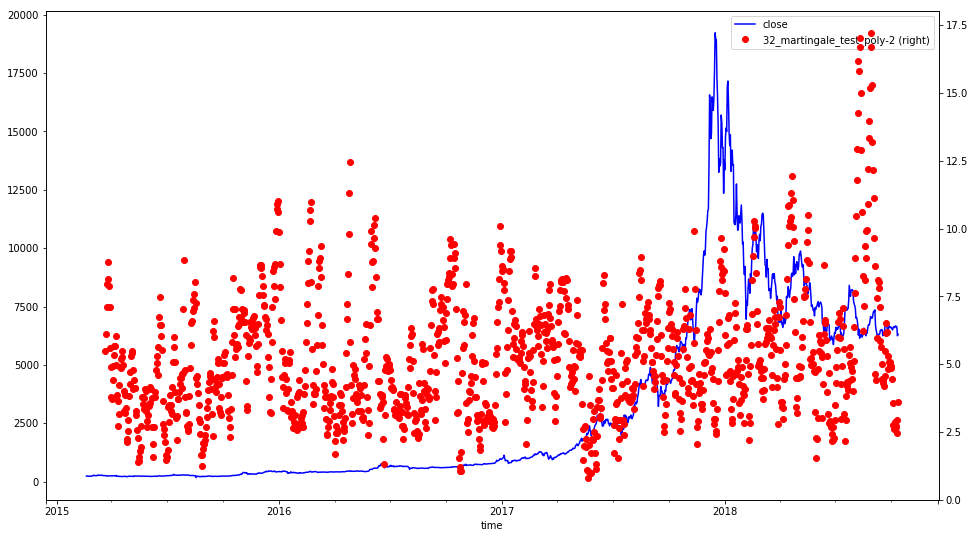

In [245]:
fig, ax = plt.subplots(figsize=(16,9))
martingale_poly2_enriched['close'].plot(ax=ax, style='b-', legend=True)
martingale_poly2_enriched['32_martingale_test_poly-2'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [246]:
features = [2,4,8,16]
for item in features:
    martingale_poly2_features = StructuralBreakFeatures(
        features_to_calculate=item)

martingale_poly2_enriched = martingale_poly2_features.get_feature_data(df_daily)
martingale_poly2_enriched.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,16_martingale_test_poly-2
time,,,,,,,,,,
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,3.663601
2018-10-09,6654.918164,1539043200,6678.999987,6610.000000,6674.063726,238.709058,1.587726e+06,6651.299989,2018-10-09,3.694580
2018-10-10,6630.200000,1539129600,6655.999998,6500.000000,6655.999998,458.869558,3.018852e+06,6578.889060,2018-10-10,2.967654
2018-10-11,6250.284490,1539216000,6632.776373,6202.349831,6630.200000,1927.565051,1.222207e+07,6340.678237,2018-10-11,3.006903
2018-10-12,6317.472516,1539302400,6326.969000,6200.000000,6253.000000,202.688348,1.266891e+06,6250.437690,2018-10-12,3.491633


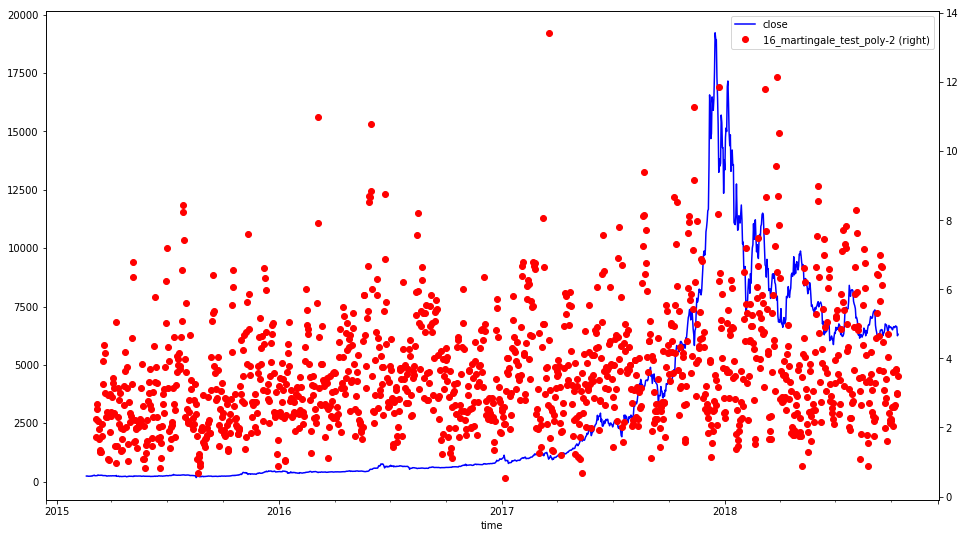

In [247]:
fig, ax = plt.subplots(figsize=(16,9))
martingale_poly2_enriched['close'].plot(ax=ax, style='b-', legend=True)
martingale_poly2_enriched['16_martingale_test_poly-2'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [248]:
features = [2,4,8]
for item in features:
    martingale_poly2_features = StructuralBreakFeatures(
        features_to_calculate=item)

martingale_poly2_enriched = martingale_poly2_features.get_feature_data(df_daily)
martingale_poly2_enriched.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,8_martingale_test_poly-2
time,,,,,,,,,,
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,0.997919
2018-10-09,6654.918164,1539043200,6678.999987,6610.000000,6674.063726,238.709058,1.587726e+06,6651.299989,2018-10-09,1.052112
2018-10-10,6630.200000,1539129600,6655.999998,6500.000000,6655.999998,458.869558,3.018852e+06,6578.889060,2018-10-10,1.827591
2018-10-11,6250.284490,1539216000,6632.776373,6202.349831,6630.200000,1927.565051,1.222207e+07,6340.678237,2018-10-11,3.358061
2018-10-12,6317.472516,1539302400,6326.969000,6200.000000,6253.000000,202.688348,1.266891e+06,6250.437690,2018-10-12,2.122256


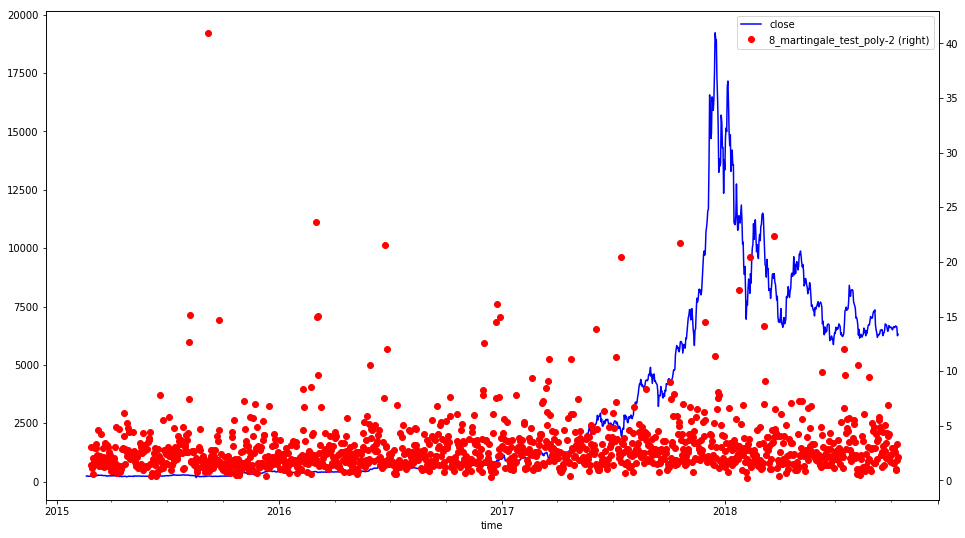

In [249]:
fig, ax = plt.subplots(figsize=(16,9))
martingale_poly2_enriched['close'].plot(ax=ax, style='b-', legend=True)
martingale_poly2_enriched['8_martingale_test_poly-2'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [250]:
features = [2,4]
for item in features:
    martingale_poly2_features = StructuralBreakFeatures(
        features_to_calculate=item)

martingale_poly2_enriched = martingale_poly2_features.get_feature_data(df_daily)
martingale_poly2_enriched.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,4_martingale_test_poly-2
time,,,,,,,,,,
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,31.914546
2018-10-09,6654.918164,1539043200,6678.999987,6610.000000,6674.063726,238.709058,1.587726e+06,6651.299989,2018-10-09,0.418794
2018-10-10,6630.200000,1539129600,6655.999998,6500.000000,6655.999998,458.869558,3.018852e+06,6578.889060,2018-10-10,2.553191
2018-10-11,6250.284490,1539216000,6632.776373,6202.349831,6630.200000,1927.565051,1.222207e+07,6340.678237,2018-10-11,2.305585
2018-10-12,6317.472516,1539302400,6326.969000,6200.000000,6253.000000,202.688348,1.266891e+06,6250.437690,2018-10-12,0.258064


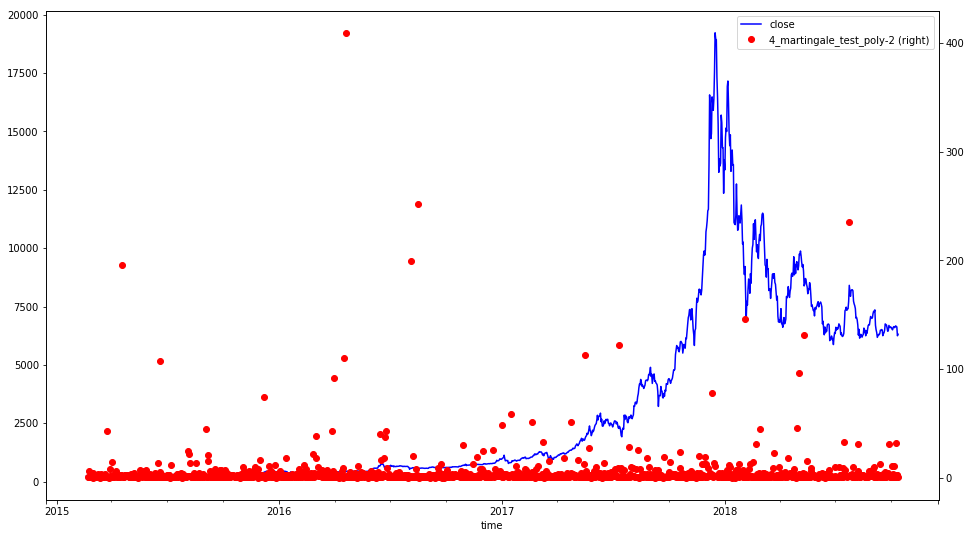

In [251]:
fig, ax = plt.subplots(figsize=(16,9))
martingale_poly2_enriched['close'].plot(ax=ax, style='b-', legend=True)
martingale_poly2_enriched['4_martingale_test_poly-2'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [252]:
features = [2]
for item in features:
    martingale_poly2_features = StructuralBreakFeatures(
        features_to_calculate=item)

martingale_poly2_enriched = martingale_poly2_features.get_feature_data(df_daily)
martingale_poly2_enriched.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,2_martingale_test_poly-2
time,,,,,,,,,,
2018-10-08,6674.063726,1538956800,6716.000000,6589.841050,6607.938895,378.845750,2.521344e+06,6655.331202,2018-10-08,0.0
2018-10-09,6654.918164,1539043200,6678.999987,6610.000000,6674.063726,238.709058,1.587726e+06,6651.299989,2018-10-09,0.0
2018-10-10,6630.200000,1539129600,6655.999998,6500.000000,6655.999998,458.869558,3.018852e+06,6578.889060,2018-10-10,0.0
2018-10-11,6250.284490,1539216000,6632.776373,6202.349831,6630.200000,1927.565051,1.222207e+07,6340.678237,2018-10-11,0.0
2018-10-12,6317.472516,1539302400,6326.969000,6200.000000,6253.000000,202.688348,1.266891e+06,6250.437690,2018-10-12,0.0


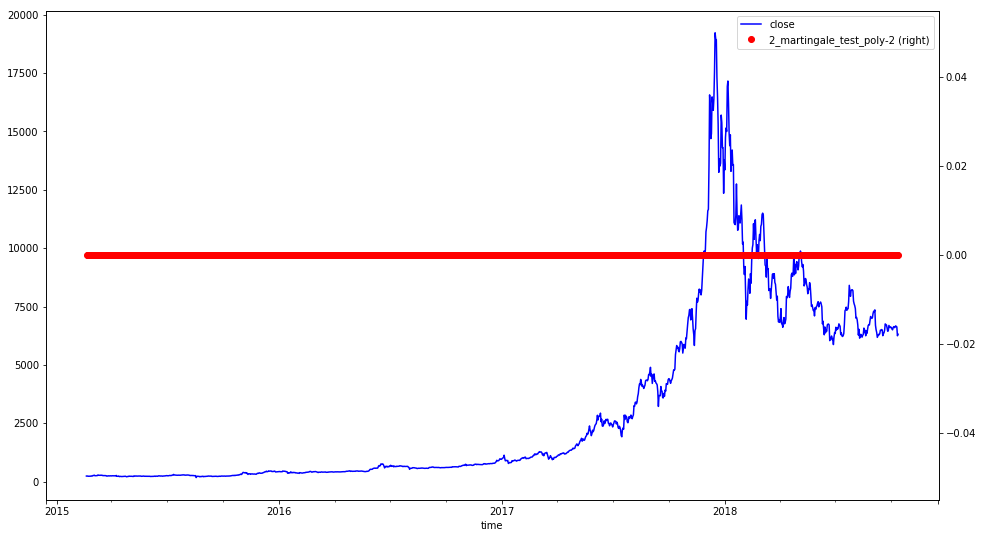

In [253]:
fig, ax = plt.subplots(figsize=(16,9))
martingale_poly2_enriched['close'].plot(ax=ax, style='b-', legend=True)
martingale_poly2_enriched['2_martingale_test_poly-2'].plot(ax=ax, style='ro', secondary_y=True, legend=True)